# The Metagalactic UV Background

One of the main motivations for ARES was to be able to easily generate models for the metagalactic background. In this example, we'll focus on the ultraviolet background , which is noteworthy given the ''sawtooth'' modulation (e.g., [Haiman et al. (1997)](http://adsabs.harvard.edu/abs/1997ApJ...476..458H)) caused by intergalactic hydrogen atoms.

In order to model this background, we need to decide on a few main ingredients:

* The spectrum of sources, which can be one of several pre-defined options (like a power-law, ``pl`` or blackbody, ``bb``), or a Python function supplied by the user.
* How the background will evolve with redshift, which could be based on the rate of collapse onto dark matter haloes as a function of time, a parameterized form for the star-formation rate history, or more detailed models of star-formation (see [this example](../uth_pop_sfrd.html)).
* What (if any) approximations we'll make in order to speed-up the calculation, aside from the assumption of a spatially uniform radiation background, which we make implicitly in ARES throughout.

First things first:

In [1]:
%pylab inline
import ares
import numpy as np
import matplotlib.pyplot as pl
from ares.physics.Constants import erg_per_ev, c, ev_per_hz

Populating the interactive namespace from numpy and matplotlib


Now, let's set some parameters that define the properties of the source population:

In [2]:
alpha = 0. # flat SED
beta = 0.  # flat SFRD
    
pars = \
{
 'pop_sfr_model': 'sfrd-func',
 'pop_sfrd': lambda z: 0.1 * (1. + z)**beta,


 'pop_sed': 'pl',
 'pop_alpha': alpha,     
 'pop_Emin': 1,
 'pop_Emax': 1e2,
 'pop_EminNorm': 13.6,
 'pop_EmaxNorm': 1e2,
 'pop_rad_yield': 1e57,
 'pop_rad_yield_units': 'photons/msun',


 # Solution method
 'pop_solve_rte': True,
 'lya_nmax': 8,
 'tau_redshift_bins': 400,


 'initial_redshift': 40,
 'final_redshift': 10,
}

To summarize these inputs, we've got:

* A constant SFRD of $0.1 \ M_{\odot} \ \mathrm{yr}^{-1} \ \mathrm{cMpc}^{-3}$, given by the ``pop_sfrd`` parameter.
* A flat spectrum (power-law with index $\alpha=0$), given by ``pop_sed`` and ``pop_alpha``.
* A yield of $10^{57} \ \mathrm{photons} \ M_{\odot}^{-1}$ of star-formation in the $13.6 \leq h\nu / \mathrm{eV} \leq  100$ band, set by ``pop_EminNorm``, ``pop_EmaxNorm``, ``pop_yield``, and ``pop_yield_units``.

See [this page](../params_populations.html) for a complete listing of parameters relevant to :class:`ares.populations.GalaxyPopulation` objects.

Next, let's initialize an :class:`ares.simulations.MetaGalacticBackground` object (which will automatically create an :class:`ares.populations.GalaxyPopulation` instance):

In [3]:
mgb = ares.simulations.MetaGalacticBackground(**pars)

To run the thing:

In [4]:
mgb.run()

The results of the calculation, as in any ``ares.simulations`` class, are stored in an attribute called ``history``. Here, we'll use a convenience routine to extract the redshifts, photon energies, and corresponding fluxes (a 2-D array):

In [5]:
z, E, flux = mgb.get_history(flatten=True)

Internally, fluxes are computed in units of $\mathrm{s}^{-1} \ \mathrm{cm}^{-2} \ \mathrm{Hz}^{-1} \ \mathrm{sr}^{-1}$, but often it can be useful to look at the background flux in terms of its energy, i.e., in units of $\mathrm{erg} \ \mathrm{s}^{-1} \ \mathrm{cm}^{-2} \ \mathrm{Hz}^{-1} \ \mathrm{sr}^{-1}$:


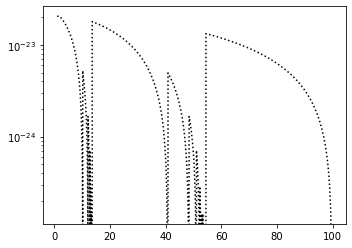

In [6]:
pl.semilogy(E, flux[0] * E * erg_per_ev, color='k', ls=':')

You should see the characteristic sawtooth modulation of an intrinsically flat spectrum.
        
Compare to the analytic solution, given by Equation A1 in [Mirocha (2014)](http://adsabs.harvard.edu/abs/2014arXiv1406.4120M>) (the *cosmologically-limited* solution to the radiative transfer equation), which does *not* take into account the sawtooth modulation:

$J_{\nu}(z) = \frac{c}{4\pi} \frac{\epsilon_{\nu}(z)}{H(z)} \frac{(1 + z)^{9/2-(\alpha + \beta)}}{\alpha+\beta-3/2} \times \left[(1 + z_i)^{\alpha+\beta-3/2} - (1 + z)^{\alpha+\beta-3/2}\right]$

with $\alpha = \beta = 0$ (i.e., constant SFRD, flat spectrum), $z=10$, and $`z_i=40$,

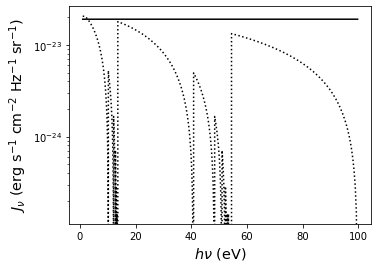

In [7]:
# Grab the GalaxyPopulation instance
pop = mgb.pops[0] 
    

# Compute cosmologically-limited solution
zi, zf = 40., 10.
e_nu = np.array([pop.Emissivity(zf, energy) for energy in E])
e_nu *= (1. + zf)**(4.5 - (alpha + beta)) / 4. / np.pi \
    / pop.cosm.HubbleParameter(zf) / (alpha + beta - 1.5)
e_nu *= ((1. + zi)**(alpha + beta - 1.5) - (1. + zf)**(alpha + beta - 1.5))
e_nu *= c * ev_per_hz
    
# Plot numerical solution again
pl.semilogy(E, flux[0] * E * erg_per_ev, color='k', ls=':')
    
# Plot analytic solution
pl.semilogy(E, e_nu, color='k', ls='-')
pl.xlabel(ares.util.labels['E'])
pl.ylabel(ares.util.labels['flux_E'])
    

pl.savefig('ares_crte_uv.png')

**NOTE:** In reality, the ionizing background before reionization should be heavily damped. This example is unphysical in some sense because while it treats the opacity of HI and HeI Lyman lines (which produce the sawtooth modulation) it ignores the continuum opacity at energies above 13.6 eV. This will be treated more carefully by setting ``pop_approx_tau='neutral'`` in [Example: X-ray background](example_crb_xr).